# Clasificación con el Algoritmo K Nearest Neighbors



**Objetivo:**
Aplicar el algoritmo de *K-Nearest Neighbors (KNN)* para clasificar reseñas en función de su número de palabras y su valor de sentimiento.

**Contexto:**
Disponemos de un dataset `reviews_sentiment.csv` que contiene 257 registros con Opiniones de usuarios sobre una app (Reviews)
Cada reseña tiene asignado un número de palabras (`wordcount`), una puntuación de sentimiento (`sentimentValue`) y una valoración global (`Star Rating`).

Para este ejercicio vamos a trabajar con **257 reseñas de usuarios sobre una aplicación**. Usaremos **dos columnas de datos** para alimentar nuestro algoritmo.

Solo emplearemos **dos características (features)** porque queremos poder **representarlas en un gráfico de dos dimensiones**. En un caso real, normalmente usaríamos **más variables** para obtener resultados más precisos, pero aquí lo hacemos con fines didácticos.

Las dos columnas que utilizaremos son:

* **wordcount**: la cantidad de palabras que tiene cada opinión.
* **sentimentValue**: un valor que va de **-4 a 4** y que indica si el comentario tiene un tono **negativo o positivo**.

Como **etiquetas** (labels) usaremos las **estrellas** que los usuarios dieron a la app (de **1 a 5**). En general, **más estrellas** suelen reflejar un **sentimiento positivo**, aunque no siempre coincide exactamente.


## 1. Importanción de librerías

En este bloque de código estamos **preparando el entorno de trabajo** importando todas las librerías que usaremos:

* **pandas** y **numpy** → para manejar y procesar los datos.
* **matplotlib** y **seaborn** → para crear gráficas y visualizar los resultados.
* Los comandos de configuración (`%matplotlib inline`, `plt.rcParams`, `plt.style.use`) sirven para **mostrar las gráficas dentro del notebook** y darles un estilo visual agradable.
* **scikit-learn (sklearn)** → para trabajar con el algoritmo de *machine learning* (en este caso, el **K-Nearest Neighbors** o KNN), dividir los datos en conjuntos de entrenamiento y prueba, escalar variables y evaluar el modelo con métricas como precisión, matriz de confusión y reporte de clasificación.

En resumen, con este bloque dejamos listas las herramientas necesarias para manejar datos, graficar y entrenar nuestro modelo.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

<div style="background-color:green;color:white">

## 2. Cargar y explorar los datos

Carga en un dataframe el reviews_sentiment.csv y muestra las primeras 10 filas. ¿De qué trata este dataset? Utiliza funciones de EDA para entender su contenido y sus opciones.

In [41]:
# Cargar el dataset
df=pd.read_csv('data/reviews_sentiment.csv', sep=';')
# Mostrar las primeras filas
df.head()


,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784


In [42]:
# Mostrar la información del DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Review Title    257 non-null    object 
 1   Review Text     257 non-null    object 
 2   wordcount       257 non-null    int64  
 3   titleSentiment  231 non-null    object 
 4   textSentiment   257 non-null    object 
 5   Star Rating     257 non-null    int64  
 6   sentimentValue  257 non-null    float64
dtypes: float64(1), int64(2), object(4)
memory usage: 14.2+ KB


Hay nulos en la columna titleSentiment, mejor arreglarlos.

In [43]:
# mostrar estadísticas descriptivas
df.describe()

,wordcount,Star Rating,sentimentValue
count,257.000000,257.000000,257.000000
mean,11.501946,3.420233,0.383849
std,13.159812,1.409531,0.897987
min,1.000000,1.000000,-2.276469
25%,3.000000,3.000000,-0.108144
50%,7.000000,3.000000,0.264091
75%,16.000000,5.000000,0.808384
max,103.000000,5.000000,3.264579


wordcount deberiamos de normalizar, Star Rating esta mas estandarizado y sentimentValue se nos dispararía un poco

<div style="background-color:green;color:white">

¿Qué representa cada variable del conjunto de datos?

¿Hay valores atípicos o ausentes que podrían afectar al modelo?

wordcount: la cantidad de palabras que tiene cada opinión.

sentimentValue: un valor que va de -4 a 4 y que indica si el comentario tiene un tono negativo o positivo.

Star Rating las estrellas que usuarios dieron a la app de 1 a 5.

Si que hay valores atípicos en wordcount y en Star Rating

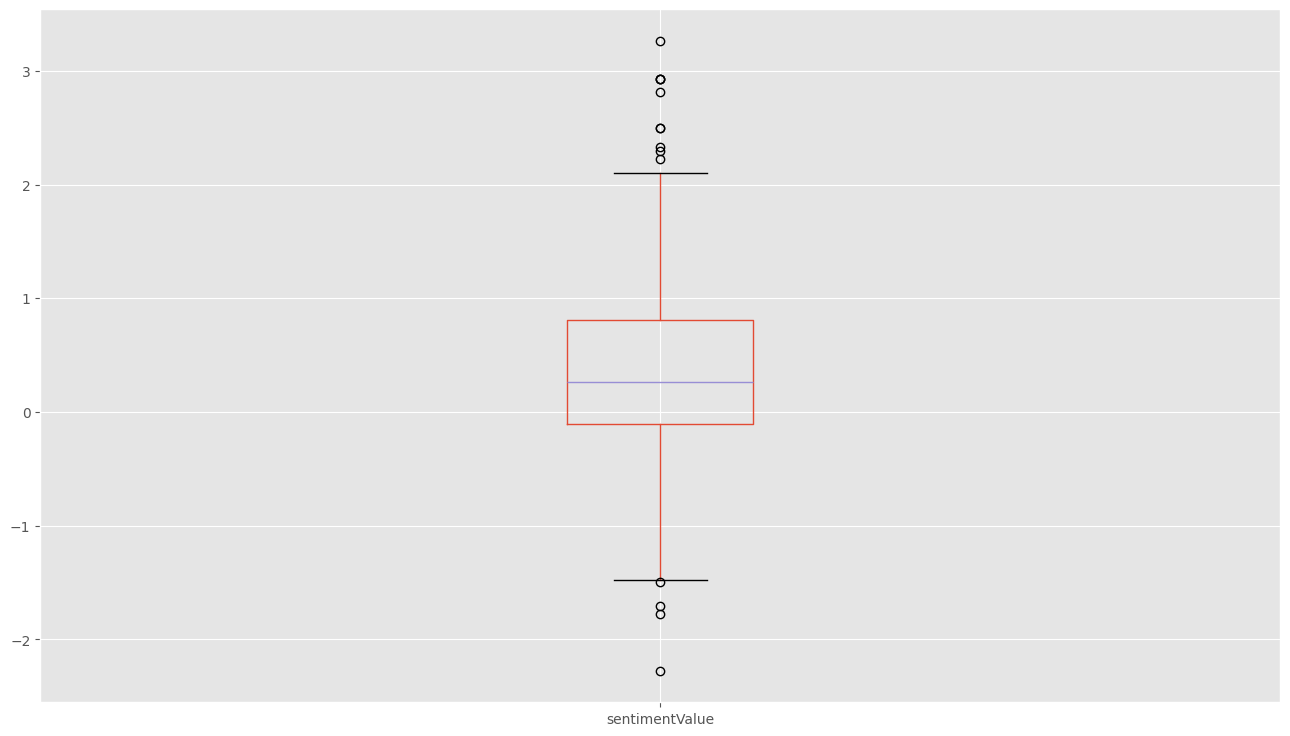

In [44]:
df.boxplot(column=['sentimentValue'])
plt.show()

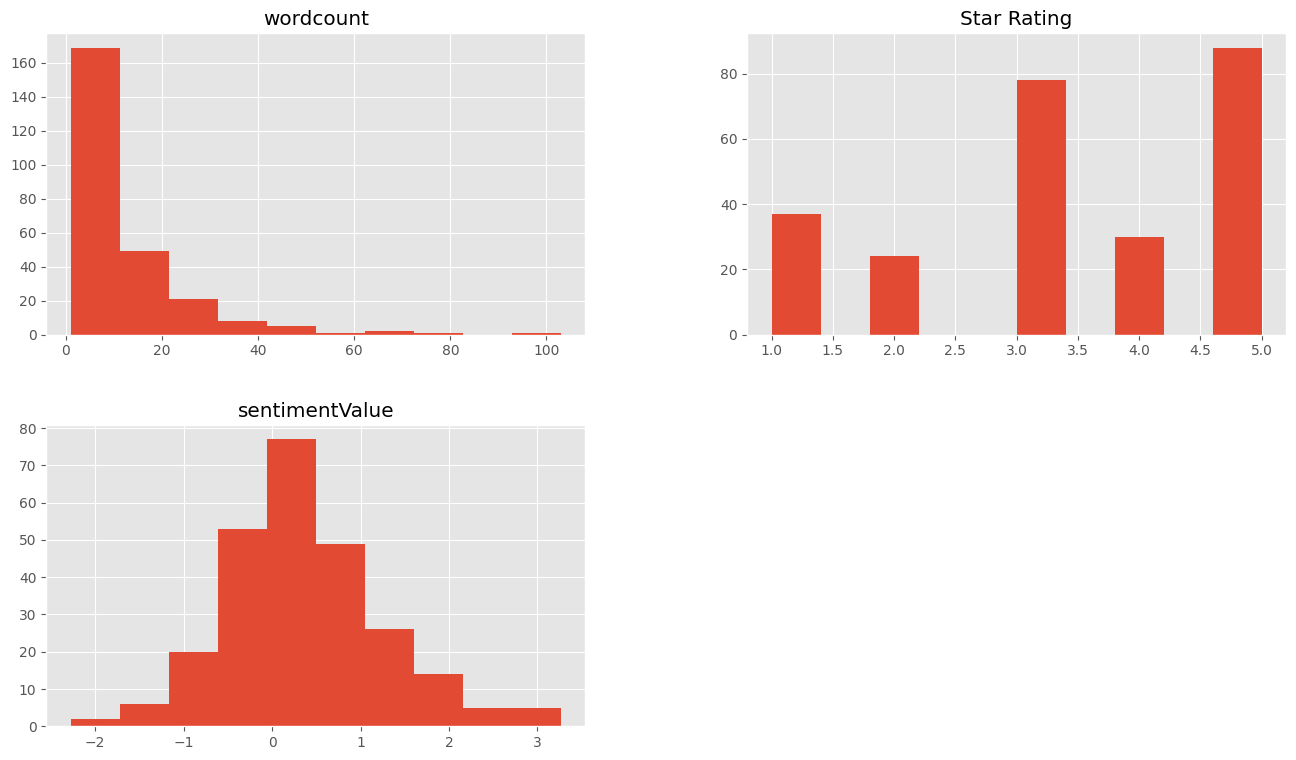

In [45]:
# Mostrar histogramas de las características
df.hist()
plt.show()

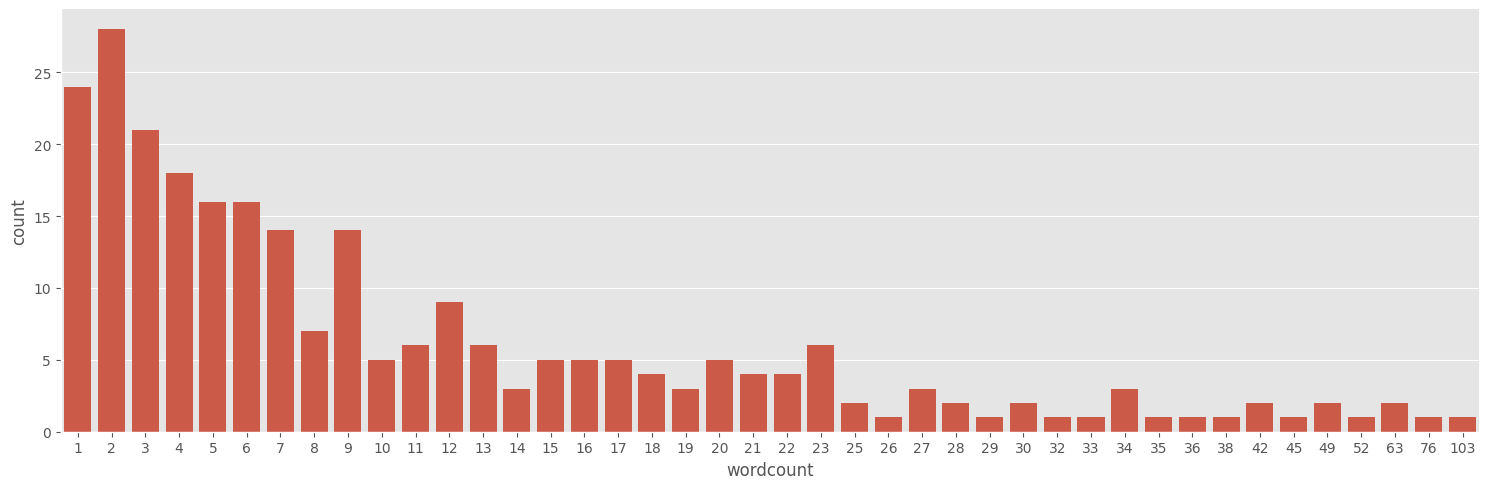

In [46]:
# Mostrar gráfico de conteo de la columna 'wordcount'
sb.catplot(x='wordcount', data=df, kind='count', aspect=3, )


## 2. Preparación de los datos

<div style="background-color:green;color:white">

### 2.1 Seleccionar las variables de entrada y salida

In [47]:
X=df[['wordcount', 'sentimentValue']]
y=df['Star Rating']

<div style="background-color:green;color:white">

### 2.2 Dividir en conjuntos de entrenamiento y prueba

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<div style="background-color:green;color:white">

### 2.3 Normalizar los datos

El KNN se basa en distancias, por lo que es necesario escalar las variables con z-score

In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Utilizo la normalización de Z-score porque hay valores atípicos

<div style="background-color:green;color:white">


## 3. Creación del modelo

Entrenar el modelo KNN con 5 vecinos

In [50]:

# Crear modelo con K=5
knn = KNeighborsClassifier(n_neighbors=5)

# Entrenar el modelo
knn.fit(X_train_scaled, y_train)


KNeighborsClassifier()

In [51]:
print('Accuracy of K-NN classifier on training set: {:.2f}'
      .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
      .format(knn.score(X_test_scaled, y_test)))

Accuracy of K-NN classifier on training set: 0.91
Accuracy of K-NN classifier on test set: 0.87


## 4.  Evaluar el modelo

In [52]:
y_pred = knn.predict(X_test_scaled)

print("Precisión del modelo:", accuracy_score(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nInforme de clasificación:\n", classification_report(y_test, y_pred))



Precisión del modelo: 0.8653846153846154

Matriz de confusión:
 [[ 9  1  0  0  0]
 [ 0  2  0  0  0]
 [ 2  1 11  0  0]
 [ 0  1  1  5  0]
 [ 0  0  1  0 18]]

Informe de clasificación:
               precision    recall  f1-score   support

           1       0.82      0.90      0.86        10
           2       0.40      1.00      0.57         2
           3       0.85      0.79      0.81        14
           4       1.00      0.71      0.83         7
           5       1.00      0.95      0.97        19

    accuracy                           0.87        52
   macro avg       0.81      0.87      0.81        52
weighted avg       0.90      0.87      0.87        52



## 5. Gráficos de la clasificación obtenida

Ahora vamos a graficar los resultados de la clasificación. Esta visualización nos permite ver de forma clara cómo se distribuyen las predicciones en función de las dos variables utilizadas.

Como solo usamos dos características (features), podemos representarlas en un gráfico 2D. Si tuviéramos tres, podríamos hacerlo en 3D, aunque en casos reales, con muchas más dimensiones, lo importante no sería la visualización sino el rendimiento del modelo.

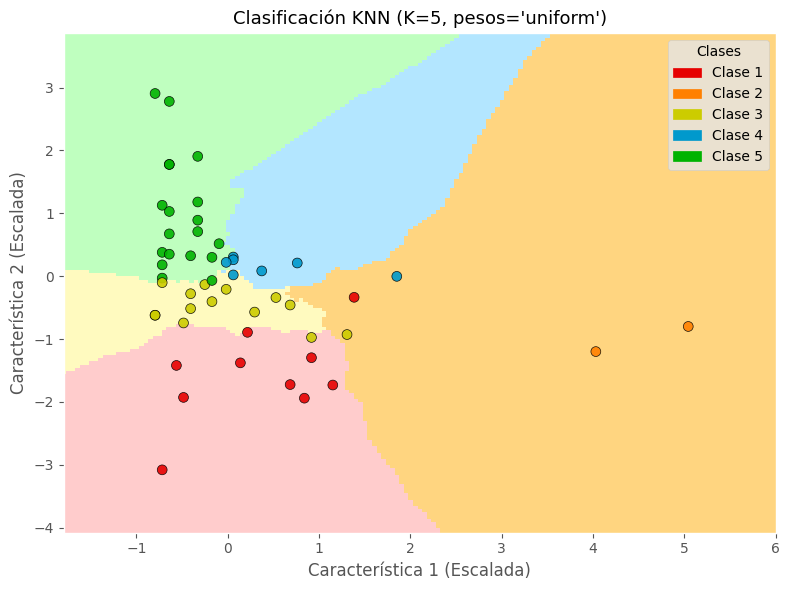

In [53]:
# Parámetros
h = 0.05  # Paso de la malla (más grande = menos resolución)

# Usar el modelo entrenado (neigh) y los datos de prueba escalados para visualización
X_plot = X_test_scaled # Usar datos de prueba escalados para graficar
y_plot = y_test        # Usar etiquetas de prueba correspondientes

# Colores más contrastados y limpios
cmap_light = ListedColormap(['#FFCCCC', '#FFD580', '#FFFABF', '#B3E6FF', '#BFFFBF'])
cmap_bold  = ListedColormap(['#E60000', '#FF8000', '#CCCC00', '#0099CC', '#00B300'])

# El clasificador 'neigh' ya está entrenado. No es necesario re-entrenar.
clf_for_plot = knn

# Creamos la malla del plano para visualizar las fronteras de decisión
x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predicción de la clase para cada punto de la malla usando el modelo entrenado (clf_for_plot)
Z = clf_for_plot.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Figura
plt.figure(figsize=(8, 6))

# Fondo coloreado por clases
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

# Puntos reales de prueba
scatter = plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap=cmap_bold,
                      edgecolor='k', s=50, alpha=0.9)

# Límites del gráfico
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Etiquetas automáticas según las clases detectadas
clases = np.unique(y_plot)
colores = cmap_bold.colors[:len(clases)]
legend_patches = [mpatches.Patch(color=colores[i], label=f'Clase {clases[i]}') for i in range(len(clases))]
plt.legend(handles=legend_patches, title='Clases', loc='upper right')

# Título
plt.title(f"Clasificación KNN (K={clf_for_plot.n_neighbors}, pesos='{clf_for_plot.weights}')", fontsize=13)
plt.xlabel("Característica 1 (Escalada)")
plt.ylabel("Característica 2 (Escalada)")

plt.tight_layout()
plt.show()


En el gráfico se distinguen **cinco zonas** que muestran la relación entre la **cantidad de palabras** (`wordcount`) y el **valor de sentimiento** (`sentimentValue`) de cada reseña.

![](img/knn-clasification-sectores.png)


Podemos interpretarlas así:

* Una reseña con unas **20 palabras** y un **sentimiento cercano a 1** se ubicaría en la zona **celeste**, correspondiente aproximadamente a una valoración de **4 estrellas**.

A partir de estas regiones se pueden intuir algunos **patrones de comportamiento de los usuarios**:

* **1 estrella:** comentarios con **sentimiento negativo** y hasta **25 palabras**.
* **2 estrellas:** usuarios que **se extienden mucho** (hasta 100 palabras) y cuyo sentimiento varía entre **negativo y ligeramente positivo**.
* **3 estrellas:** reseñas **neutrales** (sentimiento cerca de 0) con unas **25 palabras** aproximadamente.
* **5 estrellas:** opiniones **muy positivas** (sentimiento desde 0.5 en adelante) y **breves**, con menos de **10 palabras**.

En conjunto, estas zonas permiten **visualizar cómo las emociones y la extensión del texto influyen en la puntuación final** que los usuarios otorgan a la aplicación.


## 6. Cálculo del mejor K

En el algoritmo KNN, el número de vecinos (k) indica cuántos puntos cercanos se tienen en cuenta para clasificar un nuevo dato.

Si k es muy pequeño (por ejemplo, 1 o 2) → el modelo se adapta demasiado a los datos de entrenamiento (sobreajuste).

Si k es muy grande → el modelo se vuelve demasiado general y pierde precisión (subajuste).

Por eso probamos distintos valores de k y medimos cuál da mayor precisión en los datos de prueba.
El k que consigue el mejor equilibrio es el que ofrece mayor capacidad de generalización.

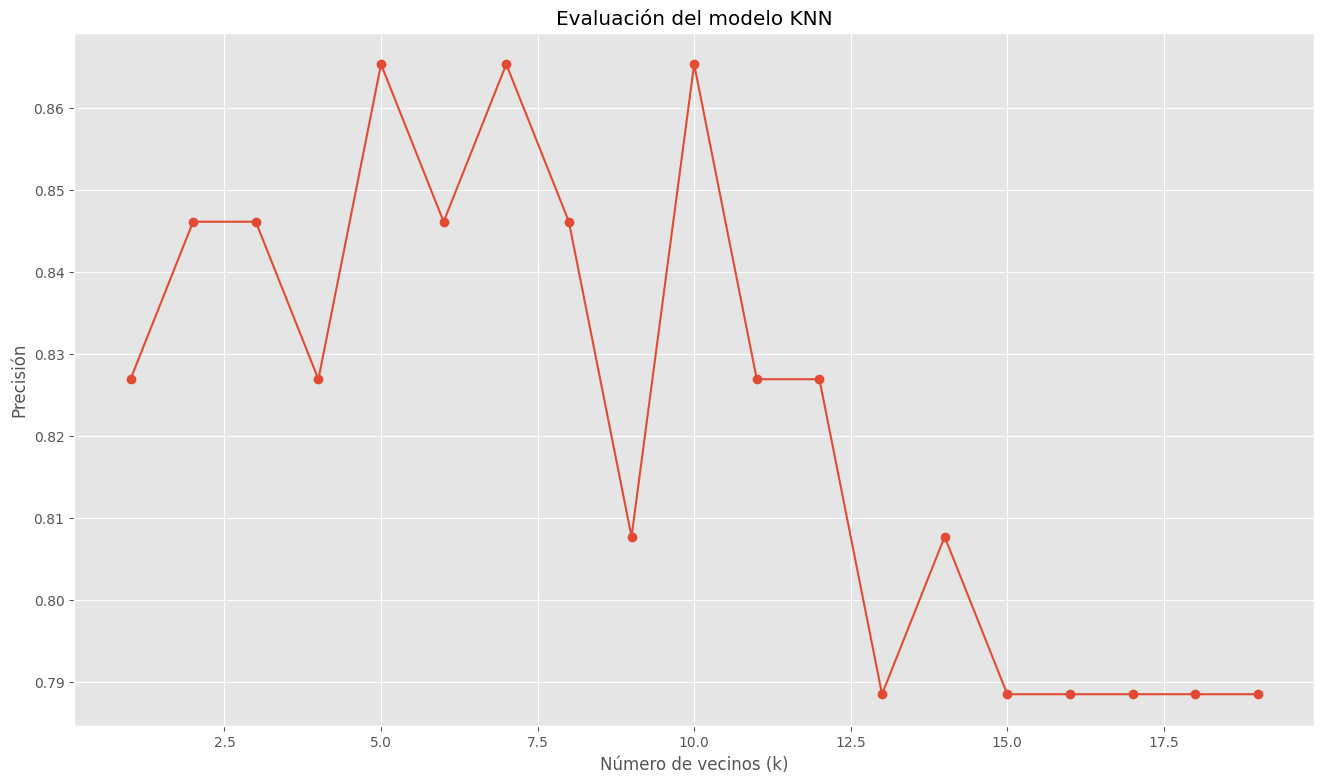

Mejor valor de k: 5 con precisión 0.87


In [54]:
k_range = range(1, 20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.figure()
plt.plot(k_range, scores, marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.title('Evaluación del modelo KNN')
plt.show()

best_k = k_range[scores.index(max(scores))]
print(f"Mejor valor de k: {best_k} con precisión {max(scores):.2f}")

En la gráfica vemos que con valores k=7 a k=14 es donde mayor precisión se logra.



## 7. Cálculo de predicciones

Vamos a pedir al modelo KNN (clf) que haga una predicción del número de estrellas para un nuevo punto con dos características:

- 5 → Representa el número de palabras (wordcount)

- 1.0 → El valor del sentimiento (sentimentValue), muy positivo

In [55]:
print(knn.predict([[5, 1.0]]))

[2]


Esto significa que, según los datos aprendidos,
una reseña con pocas palabras (5) pero sentimiento muy positivo (1.0)
probablemente obtendría una valoración de 5 estrellas.

Ahora vamos a utilizar el método ``predict_proba`` que no devuelve la clase directamente, sino las probabilidades de pertenecer a cada una de las clases posibles.

In [56]:
print(knn.predict_proba([[20, 0.0]]))

[[0.         0.94736842 0.         0.05263158 0.        ]]


En el ejemplo, para una reseña con **20 palabras** y un **sentimiento neutro (0.0)**, el resultado fue:

| Estrellas | Probabilidad |
| --------- | ------------ |
| ⭐ 1       | 0.4%         |
| ⭐ 2       | 2.5%         |
| ⭐ 3       | **97.1%**    |
| ⭐ 4       | 0%           |
| ⭐ 5       | 0%           |

El modelo calcula la **probabilidad de que una reseña pertenezca a cada categoría de estrellas** (de 1 a 5) según sus características.

El modelo considera que esa reseña tiene una **altísima probabilidad (97%) de corresponder a 3 estrellas**, lo que indica una **valoración intermedia o neutral**.

En resumen, cuando el comentario no expresa ni sentimientos muy positivos ni negativos y tiene una extensión media, el modelo predice una calificación **moderada (3 estrellas)**.


## **Ejercicio : Diagnóstico de diabetes con KNN**

### 🎯 Objetivo

Entrenar un modelo de **clasificación supervisada** usando el algoritmo **K-Nearest Neighbors (KNN)** para predecir si una persona presenta **diabetes (1)** o no (0), según distintas medidas clínicas.

---

### 📘 Contexto

El dataset `diabetes.csv` contiene observaciones médicas de mujeres mayores de 21 años con las siguientes variables:

| Variable                 | Descripción                                |
| ------------------------ | ------------------------------------------ |
| Pregnancies              | Número de embarazos                        |
| Glucose                  | Nivel de glucosa en sangre                 |
| BloodPressure            | Presión arterial diastólica                |
| SkinThickness            | Espesor del pliegue cutáneo (mm)           |
| Insulin                  | Nivel de insulina (mu U/ml)                |
| BMI                      | Índice de masa corporal                    |
| DiabetesPedigreeFunction | Factor hereditario (riesgo genético)       |
| Age                      | Edad (años)                                |
| Outcome                  | 1 = tiene diabetes / 0 = no tiene diabetes |


---
<div style="background-color:green;color:white">

## Paso 1. Cargar y explorar los datos

In [57]:
df=pd.read_csv('data/diabetes.csv', sep=',')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [58]:
# mostrar la información del DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [59]:
# Verificar duplicados en el DataFrame
df.duplicated().sum()

np.int64(0)

In [60]:
# Eliminar valores repetidos en cada columna
df.drop_duplicates(inplace=True)


In [61]:
# Mostrar estadísticas descriptivas
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [62]:
# Verificar valores nulos en el DataFrame
df.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


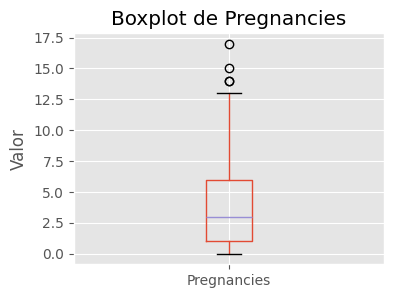

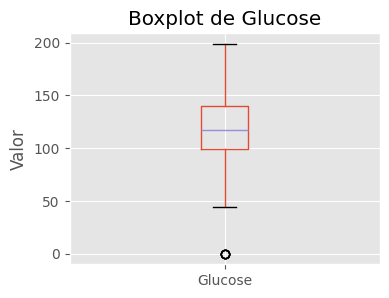

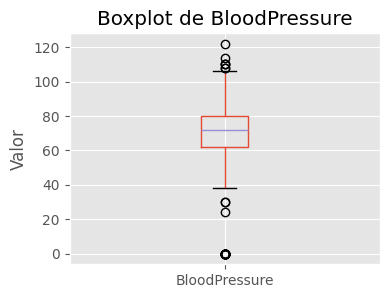

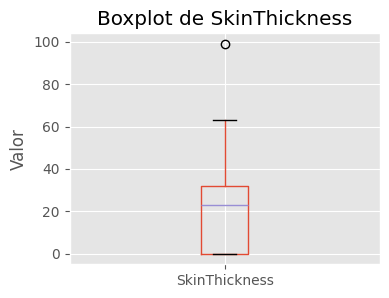

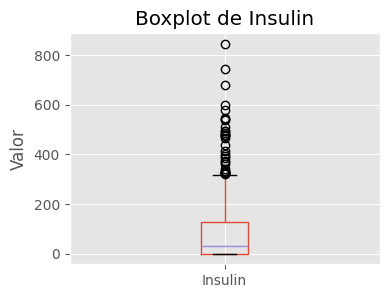

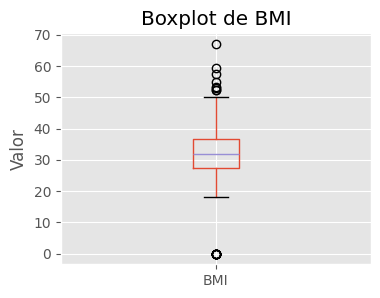

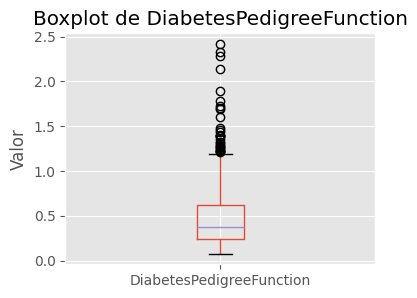

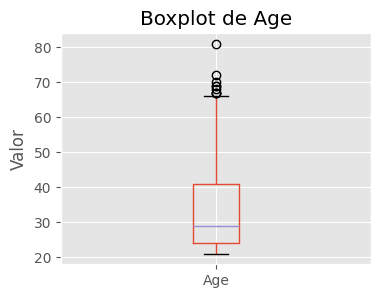

In [63]:

columns_to_plot = df.columns.drop('Outcome').tolist()

for column in columns_to_plot:
    plt.figure(figsize=(4, 3)) # Create a new figure for each boxplot
    df.boxplot(column=[column])
    plt.title(f'Boxplot de {column}') # Add a title for each plot
    plt.ylabel('Valor') # Add a y-label
    plt.grid(True) # Add a grid
    plt.show()

In [64]:
# Conteo de cada clase en la columna Outcome
conteo = df["Outcome"].value_counts()
print("Conteo de clases:\n", conteo)

# Proporción en porcentaje
proporcion = df["Outcome"].value_counts(normalize=True) * 100
print("\nProporción de clases (%):\n", proporcion)

Conteo de clases:
 Outcome
0    500
1    268
Name: count, dtype: int64

Proporción de clases (%):
 Outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64












<div style="background-color:green;color:white">

**Preguntas:**

* ¿Hay datos repetidos o nulos?
* ¿Existen outliers?
* Hay más proporción de clase 0 (no diabetes) que con clase 1 (con diabetes 1)

1. No hay valores nulos ni repetidos en el Dataframe
2. En los boxplot podemos observar:
  - Hay muchos outliers en las columnas("Age","DiabetesPedigreeFunction","Insulin")  por encima del valor máximo
    - Sugiere una alta variabilidad en estas características.
  - Hay muchos outliers en la columnaa("BMI", BloodPressure) por encima del valor máximo y pocos por debajo del valor mínimo
    - Podría indicar registros extremos o posibles errores de medición.
  - Hay pocos outliers en la columna("SkinThickness")  por encima del valor máximo y en la columna("Glucose")  por debajo del valor minimo
    - Conviene revisar los casos atípicos

3. Hay más proporción de clase 0(no diabetes)(500) que de clase 1(con diabetes)(268)
  - El desbalance puede afectar a que el modelo aprenda mejor a clasificar no diabéticos (clase 0) y peor a detectar diabéticos (clase 1).
    - Deberiamos de reducir la clase mayoritaria o aumentar la minoritaria


In [65]:
# Columnas con ceros inválidos
cols_invalidas = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

df[cols_invalidas] = df[cols_invalidas].astype(float) # Cambiar el tipo de dato para evitar futuros problemas(Columnas anteriormente tipo int)

# Reemplazar directamente los ceros por la mediana de cada columna
for col in cols_invalidas:
    median_value = df[col].median()
    df.loc[df[col] == 0, col] = median_value

# Verificar que ya no hay ceros
print(df[cols_invalidas].min())

Glucose          44.0
BloodPressure    24.0
SkinThickness     7.0
Insulin          14.0
BMI              18.2
dtype: float64


<div style="background-color:green;color:white">

### Paso 2. Seleccionar variables relevantes

Eliminar la columna (axis=1) Outcome de X y dejar en y solo la columna Outcome

In [66]:
# 2. Separar variables predictoras y objetivo
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

<div style="background-color:green;color:white">

### Paso 3. Dividir en entrenamiento y prueba

Asegurarse de manenter la misma proporción de clases con el parámetro stratify

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


<div style="background-color:green;color:white">

### Paso 4. Normalizar los datos

KNN depende de las distancias, así que es importante escalar las variables:


In [68]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<div style="background-color:green;color:white">

###  Paso 5. Entrenar el modelo con un valor inicial de K

In [69]:
# Crear modelo con K=5
knn = KNeighborsClassifier(n_neighbors=12)

# Entrenar el modelo
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=12)

In [70]:
from sklearn.metrics import accuracy_score
y_pred = knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

train_pred = knn.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_pred)
print("Accuracy:", train_accuracy, test_accuracy)

Accuracy: 0.7914338919925512 0.7272727272727273


In [71]:
# Crear modelo con K=5
knn1 = KNeighborsClassifier(n_neighbors=5)

# Entrenar el modelo
knn1.fit(X_train_scaled, y_train)

# Crear modelo con K=35
knn2 = KNeighborsClassifier(n_neighbors=35)

# Entrenar el modelo
knn2.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=35)

In [72]:
y_pred = knn1.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

train_pred = knn1.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_pred)
print("Accuracy 1:", train_accuracy, test_accuracy)

y_pred = knn2.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

train_pred = knn2.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_pred)
print("Accuracy 2:", train_accuracy, test_accuracy)

Accuracy 1: 0.8342644320297952 0.7186147186147186
Accuracy 2: 0.7821229050279329 0.7402597402597403


<div style="background-color:green;color:white">

**Preguntas:**

* ¿La precisión es parecida entre entrenamiento y prueba?
* ¿Qué pasaría si usas un valor de *k* más alto o más bajo?

1. La precisión entre entrenamiento y pueba es parecida hay una variación de 0.02

2. Podria pasar lo siguiente
- K pequeño → riesgo de sobreajuste.
- K grande → riesgo de subajuste y sesgo hacia la clase mayoritaria.

### Paso 6. Buscar el mejor valor de K

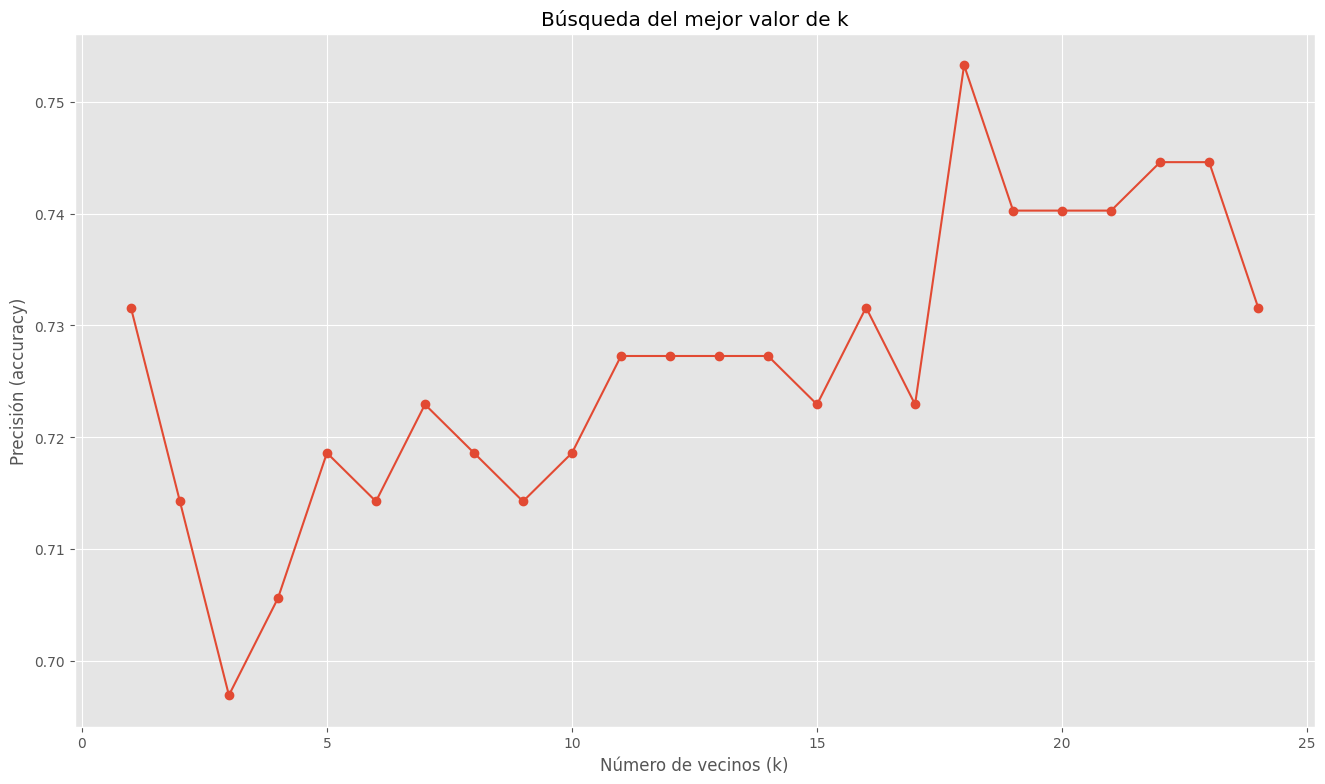

Mejor k: 18 con precisión 0.75


In [73]:
import matplotlib.pyplot as plt

k_range = range(1, 25)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.plot(k_range, scores, marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión (accuracy)')
plt.title('Búsqueda del mejor valor de k')
plt.show()

best_k = k_range[scores.index(max(scores))]
print(f"Mejor k: {best_k} con precisión {max(scores):.2f}")

<div style="background-color:green;color:white">

### Paso 7. Entrenar de nuevo el modelo con el valor óptimo de K


In [74]:
# Entrenar el modelo final con el mejor valor de k encontrado
# Crear modelo con K=18
knn4 = KNeighborsClassifier(n_neighbors=18)

# Entrenar el modelo
knn4.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=18)

<div style="background-color:green;color:white">

### Paso 8. Evaluar el modelo de clasificación

Una vez entrenado el modelo con el mejor valor de k, debemos comprobar cómo de bien distingue entre películas exitosas y no exitosas.

#### 1. Matriz de confusión

In [75]:
from sklearn.metrics import confusion_matrix

y_pred_4 = knn4.predict(X_test)
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

Matriz de confusión:
 [[133  17]
 [ 43  38]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


<div style="background-color:green;color:white">

#### 2. Informe de clasificación

In [76]:
from sklearn.metrics import classification_report

print("Informe de clasificación:\n", classification_report(y_test, y_pred, digits=3))


Informe de clasificación:
               precision    recall  f1-score   support

           0      0.756     0.887     0.816       150
           1      0.691     0.469     0.559        81

    accuracy                          0.740       231
   macro avg      0.723     0.678     0.687       231
weighted avg      0.733     0.740     0.726       231



<div style="background-color:green;color:white">

#### 3. Precisión general

In [77]:
y_pred = knn4.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

train_pred = knn4.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, train_pred)
print("Accuracy:", train_accuracy, test_accuracy)

Accuracy: 0.7951582867783985 0.7532467532467533


<div style="background-color:green;color:white">

**Reflexión**

1. ¿Qué variables parecen influir más en el diagnóstico (glucosa, IMC, edad...)?
2. ¿Qué valor de *k* produjo mejores resultados?
3. ¿Qué tipo de errores comete el modelo (falsos positivos o negativos)?
4. ¿Por qué crees que es importante normalizar los datos antes de usar KNN?

<div style="background-color:green;color:white">

### Paso 8. redicción de nuevos pacientes

Una vez entrenado y evaluado el modelo KNN, queremos utilizarlo para diagnosticar nuevos casos clínicos.

Disponemos de dos pacientes cuyas características médicas han sido registradas.

Tu tarea consiste en predecir si cada uno de ellos presenta diabetes o no según los valores introducidos.

### 🧍‍♀️ **Paciente 1**

* **Embarazos:** 5
* **Glucosa:** 165
* **Presión arterial:** 85
* **Espesor de piel:** 25
* **Insulina:** 130
* **IMC:** 35.5
* **Pedigree:** 0.63
* **Edad:** 45

👉 Se sospecha que presenta síntomas de diabetes.

---

### 🧍‍♂️ **Paciente 2**

* **Embarazos:** 1
* **Glucosa:** 90
* **Presión arterial:** 70
* **Espesor de piel:** 20
* **Insulina:** 85
* **IMC:** 22.5
* **Pedigree:** 0.35
* **Edad:** 28

👉 Se sospecha que **no presenta diabetes**.

In [78]:
pacientes = np.array([
    [5, 165, 85, 25, 130, 35.5, 0.63, 45],  # Paciente 1
    [1, 90, 70, 20, 85, 22.5, 0.35, 28]     # Paciente 2
])

# Escalar pacientes con el mismo scaler
pacientes_scaled = scaler.transform(pacientes)

# Predicción
predicciones = knn.predict(pacientes_scaled)

# Mostrar resultados
for i, pred in enumerate(predicciones, start=1):
    resultado = "Diabetes POSITIVA" if pred == 1 else "Diabetes NEGATIVA"
    print(f"Paciente {i}: {resultado}")


Paciente 1: Diabetes POSITIVA
Paciente 2: Diabetes NEGATIVA


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Webgrafia

* [Documentación scikit-learn](https://scikit-learn.org/stable/modules/neighbors.html#classification)
* [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
* [Libro "Hands on Machine Learning with ScikitLearn, Keras y TensorFlow" de Aurelien Geron y su repositorio de ejemplos ](https://github.com/ageron/handson-ml)
* [Aprende ML de Juan Ignacio Bagnato](https://www.aprendemachinelearning.com/clasificar-con-k-nearest-neighbor-ejemplo-en-python/)
* [Curso de Tirtjakupto Sarkar](https://github.com/tirthajyoti/Machine-Learning-with-Python)
* [DataCamp](https://www.datacamp.com/)


# Licencia

[Attributon-ShacerAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/)

Puedes utilizar libremente este material, con las siguientes condiciones:

* Atribuir la autoría a este documento.
* Si lo utilizas y haces cambios, deberás liberarlo también bajo la misma licencia.